In [2]:
# Reload all modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [3]:
import os
import datetime
import io
import pickle
import re
import json
import gzip
import cProfile
import lxml.etree
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
# import ray
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon, box
import geopandas as geopd
import pandas as pd
import querier as qr
from dotenv import load_dotenv
load_dotenv()

import ses_ling.data.access as data_access
import ses_ling.utils.paths as path_utils
import ses_ling.utils.geometry as geo_utils
import ses_ling.utils.spatial_agg as spatial_agg
import ses_ling.utils.text_process as text_process
from ses_ling.language import Region, Language

In [4]:
paths = path_utils.ProjectPaths()
all_cntr_shapes = geopd.read_file(paths.countries_shapefile)

In [5]:
with open(paths.ext_data / 'countries.json') as f:
    countries_dict = json.load(f)
cc = 'GB'
cc_dict = countries_dict[cc]
year_from = 2015
year_to = 2021
assign_kwargs = dict(
    nighttime_acty_th=0.5,
    all_acty_th=0.1,
    count_th=3,
)

In [6]:
_cc_init_params = {cc: {'cell_size': 'MSOA_BGC', 'ses_idx': "IMD"}}
lang = Language(
    'en', 'English', _cc_init_params, all_cntr_shapes, countries_dict,
    year_from=year_from, year_to=year_to,
    latlon_proj=cc_dict['xy_proj'], # TOCHANGE when several countries
    user_nr_words_th=100,
    cells_nr_users_th=15, # this might cause init pb because of setter
    **assign_kwargs
)

# User level

## Quick stats and checks

In [7]:
lang.user_corpora.head()

,nr_tweets,nr_words,nr_unique_words
user_id,,,
00030426231cf2773a81f9897ecbeb951cd2ee7bf2d0118694cf5292edee1720902aed6e5a30783b25d75b7171b376cb81750aef025074226c6d0211a6fb6a9f,64,2507,731
0007831e4682dde226017fbf5d97c58c537a05fd1b55bf0ca4382c3866bdecc18591c37aba8f0b40ccf4899473deb37da34e85ac3cc41e2875fa6660d0fbb955,124,1683,715
000faaaa6e11d566321800c3187781f6651521366dc43312f992b2a145a9e86447232fbb1e3c4f0e76e5ddc3f3f9000715ce6ae3f3c5e2a221c676faa28a85ec,37,445,258
001b4e7bcb4f4980e67d738ef38fe5b63f759e8cdb9938c4ac06354bb37d5f1dfe0e31e522a026e6ba70c2e4a5806b6d4cba9292d472cc6d792c68d9bf72a43c,100,1001,453
001e74edd2ca43f22a6a936eb5315f06bc62a3fcaa1ebd40a06fe05edc6f6687081134f00ba779a51c05e8379cd51c8e802d7bbd53cbaf3b864f9a16a50dc5ae,43,400,233


In [8]:
user_mistakes = lang.user_mistakes
user_mistakes.head()

count  \
user_id                                            cat_id     rule_id                               
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                    2   
                                                   GRAMMAR    DEPEND_ON                         1   
                                                              ORDER_OF_WORDS_WITH_NOT           1   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE      1   
                                                              WHITESPACE_RULE                  37   

                                                                                            nr_tweets  \
user_id                                            cat_id     rule_id                                   
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                       86   
                                                   GRAMMAR    DEPEND_ON                            86   
                                                              ORDER_OF_WORDS_WITH_NOT              86   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE         86   
                                                              WHITESPACE_RULE                      86   

                                                                                            nr_words  \
user_id                                            cat_id     rule_id                                  
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                     644   
                                                   GRAMMAR    DEPEND_ON                          644   
                                                              ORDER_OF_WORDS_WITH_NOT            644   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE       644   
                                                              WHITESPACE_RULE                    644   

                                                                                            nr_unique_words  \
user_id                                            cat_id     rule_id                                         
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                            123   
                                                   GRAMMAR    DEPEND_ON                                 123   
                                                              ORDER_OF_WORDS_WITH_NOT                   123   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE              123   
                                                              WHITESPACE_RULE                           123   

                                                                                            freq_per_word  \
user_id                                            cat_id     rule_id                                       
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                     0.003106   
                                                   GRAMMAR    DEPEND_ON                          0.001553   
                                                              ORDER_OF_WORDS_WITH_NOT            0.001553   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE       0.001553   
                                                              WHITESPACE_RULE                    0.057453   

                                                                                            freq_per_tweet  
user_id                                            cat_id     rule_id                                       
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                      0.023256  
                                                  

In [9]:
lang.user_df.head()

,nr_tweets,nr_words,nr_unique_words,cell_id
user_id,,,,
00030426231cf2773a81f9897ecbeb951cd2ee7bf2d0118694cf5292edee1720902aed6e5a30783b25d75b7171b376cb81750aef025074226c6d0211a6fb6a9f,64,2507,731,E02005567
0007831e4682dde226017fbf5d97c58c537a05fd1b55bf0ca4382c3866bdecc18591c37aba8f0b40ccf4899473deb37da34e85ac3cc41e2875fa6660d0fbb955,124,1683,715,E02001640
000faaaa6e11d566321800c3187781f6651521366dc43312f992b2a145a9e86447232fbb1e3c4f0e76e5ddc3f3f9000715ce6ae3f3c5e2a221c676faa28a85ec,37,445,258,E02005173
001b4e7bcb4f4980e67d738ef38fe5b63f759e8cdb9938c4ac06354bb37d5f1dfe0e31e522a026e6ba70c2e4a5806b6d4cba9292d472cc6d792c68d9bf72a43c,100,1001,453,E02006801
001e74edd2ca43f22a6a936eb5315f06bc62a3fcaa1ebd40a06fe05edc6f6687081134f00ba779a51c05e8379cd51c8e802d7bbd53cbaf3b864f9a16a50dc5ae,43,400,233,E02004279


In [104]:
lang.user_df['nr_words'].describe()

count    3.583340e+05
mean     3.475908e+03
std      1.460625e+04
min      4.000000e+00
25%      3.060000e+02
50%      8.020000e+02
75%      2.201000e+03
max      2.125035e+06
Name: nr_words, dtype: float64

In [ ]:
lang.user_nr_words_th = 100

In [278]:
user_mistakes_cat = lang.user_mistakes.groupby(['user_id', 'cat_id']).sum()

In [93]:
user_mistakes_cat.head()

cat_count  \
user_id                                            cat_id                  
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING              2   
                                                   GRAMMAR             2   
                                                   TYPOGRAPHY         38   
                                                   TYPOS               3   
00001a1b91726d1cd5d01471c6166c9fb93fdba2872ca96... CASING             10   

                                                               cat_freq_per_word  \
user_id                                            cat_id                          
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING               0.003106   
                                                   GRAMMAR              0.003106   
                                                   TYPOGRAPHY           0.059006   
                                                   TYPOS                0.004658   
00001a1b91726d1cd5d01471c6166c9fb93fdba2872ca96... CASING               0.010515   

                                                               cat_freq_per_tweet  
user_id                                            cat_id                          
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING                0.023256  
                                                   GRAMMAR               0.023256  
                                                   TYPOGRAPHY            0.441860  
                                                   TYPOS                 0.034884  
00001a1b91726d1cd5d01471c6166c9fb93fdba2872ca96... CASING                0.112360

In [76]:
# Most common mistakes
# full_user_mistakes_cat = user_mistakes_cat.unstack(level=1).stack(dropna=False).fillna(0)
# full_user_mistakes_cat.groupby('cat_id').mean().sort_values(by='cat_freq_per_word', ascending=False)
(user_mistakes_cat.groupby('cat_id').sum() / user_mistakes_cat.index.levels[0].size).sort_values(by='freq_per_word', ascending=False)

,cat_freq_per_word,cat_freq_per_tweet
cat_id,,
TYPOGRAPHY,0.023225,0.306905
CASING,0.007341,0.090328
PUNCTUATION,0.006666,0.088851
TYPOS,0.00384,0.048111
GRAMMAR,0.003474,0.044675
MISC,0.001605,0.021474
STYLE,0.001238,0.015237
CONFUSED_WORDS,0.000618,0.007746
REDUNDANCY,0.000207,0.002938


# Cell level

In [ ]:
lang.cells_geodf['nr_users'].describe()

count    7201.000000
mean       49.761700
std       111.547232
min         2.000000
25%        16.000000
50%        24.000000
75%        63.000000
max      7955.000000
Name: nr_users, dtype: float64

In [114]:
lang.cells_nr_users_th = 15

In [140]:
lang.cells_mistakes

count  uavg_freq_per_word  \
cell_id   cat_id rule_id                                           
E02000001 CASING CAPITALIZATION           38        1.191085e-06   
                 CHRISTMAS                72        2.448124e-06   
                 EN_SPECIFIC_CASE        569        1.265377e-05   
                 FILE_EXTENSIONS_CASE     28        4.600780e-07   
                 HALLOWEEN                 9        4.238288e-07   
...                                      ...                 ...   
W02000423 TYPOS  WERE_VBB                  1        2.433605e-07   
                 WHOS                      1        6.673460e-07   
                 WHOS_NN                   2        9.369226e-07   
                 WIFI                      5        2.064774e-06   
                 YOUR_YOU_2                3        1.237478e-05   

                                       uavg_freq_per_tweet  
cell_id   cat_id rule_id                                    
E02000001 CASING CAPITALIZATION                   0.000016  
                 CHRISTMAS                        0.000034  
                 EN_SPECIFIC_CASE                 0.000174  
                 FILE_EXTENSIONS_CASE             0.000007  
                 HALLOWEEN                        0.000004  
...                                                    ...  
W02000423 TYPOS  WERE_VBB                         0.000002  
                 WHOS                             0.000007  
                 WHOS_NN                          0.000012  
                 WIFI                             0.000022  
                 YOUR_YOU_2                       0.000147  

[2181731 rows x 3 columns]

In [293]:
lang.cells_mistakes.groupby(['cell_id', 'cat_id']).sum()['uavg_freq_per_word'].unstack()

cat_id,CASING,COLLOCATIONS,COMPOUNDING,CONFUSED_WORDS,GRAMMAR,MISC,NONSTANDARD_PHRASES,PUNCTUATION,REDUNDANCY,REPETITIONS_STYLE,SEMANTICS,STYLE,TYPOGRAPHY,TYPOS
cell_id,,,,,,,,,,,,,,
E02000001,0.000465,0.000006,0.000012,0.000029,0.000207,0.000112,2.138935e-06,0.000423,0.000021,6.111762e-07,2.945498e-06,0.000062,0.003596,0.000175
E02000002,0.000802,0.000003,NaN,0.000033,0.000086,0.000306,5.116791e-06,0.000489,NaN,NaN,NaN,0.000026,0.000939,0.000433
E02000003,0.000453,0.000015,0.000006,0.000069,0.000162,0.000147,NaN,0.000439,0.000007,NaN,NaN,0.000110,0.001358,0.000366
E02000004,0.000308,0.000016,0.000103,0.000034,0.000240,0.000094,NaN,0.000559,0.000020,NaN,NaN,0.000178,0.001841,0.000419
E02000005,0.000131,0.000004,0.000004,0.000015,0.000096,0.000030,2.593484e-08,0.000235,0.000016,NaN,3.540931e-07,0.000044,0.000417,0.000134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W02000419,0.000367,0.000002,0.000025,0.000078,0.000217,0.000030,8.169769e-07,0.000331,0.000005,NaN,4.161196e-07,0.000093,0.000646,0.000223
W02000420,0.000385,0.000006,0.000011,0.000028,0.000170,0.000088,1.928625e-07,0.000353,0.000009,1.590277e-07,5.885650e-07,0.000042,0.001058,0.000141
W02000421,0.000337,0.000002,0.000016,0.000024,0.000144,0.000074,1.376747e-07,0.000303,0.000008,NaN,1.252527e-06,0.000034,0.001326,0.000167


### Viz single cat/rule

(<Figure size 283.465x386.429 with 2 Axes>, (<AxesSubplot:>,))

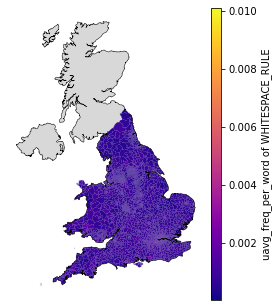

In [330]:
lang.map_mistake('WHITESPACE_RULE', normed_bboxes=False, total_width=100)

(<Figure size 283.465x386.429 with 2 Axes>, (<AxesSubplot:>,))

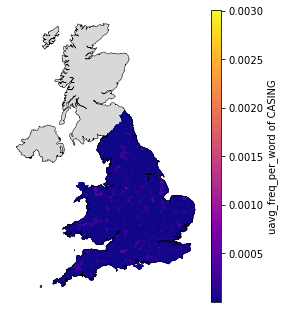

In [332]:
lang.map_cat('CASING', normed_bboxes=False, total_width=100)

In [63]:
lang.cells_mistakes

count  uavg_freq_per_word  \
cell_id   cat_id rule_id                                           
E02000001 CASING AI                        1        7.845845e-06   
                 CAPITALIZATION           38        1.173815e-06   
                 CHRISTMAS                72        2.412628e-06   
                 EN_SPECIFIC_CASE        571        1.487956e-05   
                 FILE_EXTENSIONS_CASE     28        4.534073e-07   
...                                      ...                 ...   
W02000423 TYPOS  WERE_VBB                  1        2.387074e-07   
                 WHOS                      1        6.545861e-07   
                 WHOS_NN                   2        9.190083e-07   
                 WIFI                      5        2.025294e-06   
                 YOUR_YOU_2                3        1.213817e-05   

                                       uavg_freq_per_tweet  
cell_id   cat_id rule_id                                    
E02000001 CASING AI                               0.000055  
                 CAPITALIZATION                   0.000016  
                 CHRISTMAS                        0.000033  
                 EN_SPECIFIC_CASE                 0.000190  
                 FILE_EXTENSIONS_CASE             0.000007  
...                                                    ...  
W02000423 TYPOS  WERE_VBB                         0.000002  
                 WHOS                             0.000007  
                 WHOS_NN                          0.000012  
                 WIFI                             0.000022  
                 YOUR_YOU_2                       0.000145  

[2184130 rows x 3 columns]

In [65]:
lang.cells_mistakes.groupby(['cell_id', 'cat_id'])['uavg_freq_per_word'].sum().unstack().fillna(0)

cat_id,CASING,COLLOCATIONS,COMPOUNDING,CONFUSED_WORDS,GRAMMAR,MISC,NONSTANDARD_PHRASES,PUNCTUATION,REDUNDANCY,REPETITIONS_STYLE,SEMANTICS,STYLE,TYPOGRAPHY,TYPOS
cell_id,,,,,,,,,,,,,,
E02000001,0.000465,0.000006,0.000012,0.000029,0.000207,0.000112,2.138935e-06,0.000423,0.000021,6.111762e-07,2.945498e-06,0.000062,0.003596,0.000175
E02000002,0.000802,0.000003,NaN,0.000033,0.000086,0.000306,5.116791e-06,0.000489,NaN,NaN,NaN,0.000026,0.000939,0.000433
E02000003,0.000453,0.000015,0.000006,0.000069,0.000162,0.000147,NaN,0.000439,0.000007,NaN,NaN,0.000110,0.001358,0.000366
E02000004,0.000308,0.000016,0.000103,0.000034,0.000240,0.000094,NaN,0.000559,0.000020,NaN,NaN,0.000178,0.001841,0.000419
E02000005,0.000131,0.000004,0.000004,0.000015,0.000096,0.000030,2.593484e-08,0.000235,0.000016,NaN,3.540931e-07,0.000044,0.000417,0.000134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W02000419,0.000367,0.000002,0.000025,0.000078,0.000217,0.000030,8.169769e-07,0.000331,0.000005,NaN,4.161196e-07,0.000093,0.000646,0.000223
W02000420,0.000385,0.000006,0.000011,0.000028,0.000170,0.000088,1.928625e-07,0.000353,0.000009,1.590277e-07,5.885650e-07,0.000042,0.001058,0.000141
W02000421,0.000337,0.000002,0.000016,0.000024,0.000144,0.000074,1.376747e-07,0.000303,0.000008,NaN,1.252527e-06,0.000034,0.001326,0.000167


In [66]:
cat_avg_freq = lang.cells_mistakes.groupby(['cell_id', 'cat_id'])['uavg_freq_per_word'].sum().unstack().fillna(0)
m = lang.cells_geodf.join(cat_avg_freq, how='inner').explore('GRAMMAR')

In [71]:
m.save(lang.paths.case_figs / 'mistake_cat_freqs.html')

### SES / inter-rules/cats correlations

correlation betwen rules freqs to recover categories, see if they match LT's

also simple quesrion like: are tweets hsorter in poorer areas? pb: twitter change in 2017 of tweets' max length. should be ok if enough users per cell, but atm it's clearly not enough with the 10-20

investigate influence of neihbouring cells, communities on speech. is a poor area surrounded by rich ones going t be speaking "more standard"? correlation Gi (not star!) with cell's own z-score

count all mistakes, diversity of mistakes, aggregate from clustering 
vector of mistake freq, PCA? into hierarchical, compare with socio economical

rank correlation for when imd is just given in terms of rank?

In [333]:
lang.cells_ses_df.head()

wavg         wvar          avg           var  \
msoa11cd  metric                                                          
E02000001 gbscore     -0.610203     0.044349    -0.552000      0.386382   
          totpop    1146.065650  5490.643581  1114.500000  42215.900000   
          cypscore    -0.948809     0.131889    -0.926500      0.879443   
          empscore     0.053121     0.000352     0.050833      0.002513   
          incscore     0.065100     0.000840     0.062667      0.006066   

                        min       max  weight  nr_units       wstd  
msoa11cd  metric                                                    
E02000001 gbscore    -1.167     0.571    6687         6   0.210593  
          totpop    802.000  1350.000    6687         6  74.098877  
          cypscore   -2.107     0.338    6687         6   0.363165  
          empscore    0.010     0.136    6687         6   0.018768  
          incscore    0.007     0.211    6687         6   0.028983

In [152]:
wavg_ses = lang.cells_ses_df['wavg'].unstack()
uavg_cat_freq = lang.cells_mistakes.groupby(['cell_id', 'cat_id'])['uavg_freq_per_word'].sum().unstack().fillna(0).loc[lang.cells_mask]
# uavg_rule_freq = lang.cells_mistakes['uavg_freq_per_word'].unstack().fillna(0).droplevel(-1)
corrs = wavg_ses.join(uavg_cat_freq, how='inner',).corr()

In [154]:
corrs

,asscore,bhsscore,criscore,cypscore,eduscore,empscore,envscore,gbscore,hddscore,idcscore,...,GRAMMAR,MISC,NONSTANDARD_PHRASES,PUNCTUATION,REDUNDANCY,REPETITIONS_STYLE,SEMANTICS,STYLE,TYPOGRAPHY,TYPOS
asscore,1.000000,-0.139453,0.503206,0.811105,0.922604,0.803147,0.001780,-0.203470,0.715807,0.750405,...,0.141709,-0.012020,-0.015673,-0.021074,-0.104639,-0.027355,-0.064349,0.147288,-0.261713,0.210562
bhsscore,-0.139453,1.000000,-0.089418,-0.098671,-0.155512,-0.176424,0.263250,0.348614,-0.272412,-0.001798,...,-0.086143,-0.036097,0.032458,-0.001292,0.018350,0.048520,0.038258,0.021847,0.128853,-0.064795
criscore,0.503206,-0.089418,1.000000,0.487440,0.559259,0.656228,0.262498,-0.630916,0.649044,0.720781,...,0.078250,-0.018490,0.004297,-0.006092,-0.083500,-0.016301,-0.009606,0.121631,0.022920,0.147457
cypscore,0.811105,-0.098671,0.487440,1.000000,0.910966,0.713766,0.119454,-0.221441,0.687007,0.741983,...,0.108364,-0.005440,-0.002026,0.011874,-0.062550,-0.022434,-0.048274,0.116271,-0.157431,0.164319
eduscore,0.922604,-0.155512,0.559259,0.910966,1.000000,0.833512,0.063728,-0.271274,0.741413,0.814475,...,0.139419,0.005570,-0.003296,0.007685,-0.080968,-0.029502,-0.049989,0.132673,-0.174588,0.200003
empscore,0.803147,-0.176424,0.656228,0.713766,0.833512,1.000000,0.168555,-0.422602,0.859731,0.897122,...,0.089982,0.001411,-0.002976,-0.050581,-0.084587,-0.029569,-0.025014,0.060620,-0.102597,0.161662
envscore,0.001780,0.263250,0.262498,0.119454,0.063728,0.168555,1.000000,-0.225553,0.203757,0.256661,...,-0.125082,-0.046146,0.025502,-0.071347,-0.009472,0.012796,0.023313,-0.090664,0.158101,-0.071836
gbscore,-0.203470,0.348614,-0.630916,-0.221441,-0.271274,-0.422602,-0.225553,1.000000,-0.447740,-0.504526,...,-0.076104,-0.022726,-0.007801,-0.037850,0.015473,0.005335,-0.030636,-0.117317,-0.156820,-0.134345
hddscore,0.715807,-0.272412,0.649044,0.687007,0.741413,0.859731,0.203757,-0.447740,1.000000,0.798788,...,0.075682,-0.029818,-0.012720,-0.064941,-0.102221,-0.040809,-0.033981,0.073823,-0.166154,0.150276
idcscore,0.750405,-0.001798,0.720781,0.741983,0.814475,0.897122,0.256661,-0.504526,0.798788,1.000000,...,0.083294,-0.019402,0.004755,-0.024025,-0.068303,-0.015534,-0.009867,0.119456,-0.054522,0.163783


In [156]:
corr_mat = corrs.to_numpy('float').copy()
np.fill_diagonal(corr_mat, 0)

In [157]:
pd.Series(corrs.columns[np.argmax(np.abs(corr_mat), axis=1)], index=corrs.index)

asscore                   eduscore
bhsscore                   wbscore
criscore                  imdscore
cypscore                  eduscore
eduscore                   asscore
empscore                  incscore
envscore                  indscore
gbscore                   idoscore
hddscore                  empscore
idcscore                  incscore
idoscore                  incscore
imdscore                  incscore
incscore                  imdscore
indscore                  envscore
outscore                   wbscore
totpop                    bhsscore
wbscore                   outscore
CASING                 PUNCTUATION
COLLOCATIONS               GRAMMAR
COMPOUNDING                GRAMMAR
CONFUSED_WORDS             GRAMMAR
GRAMMAR                PUNCTUATION
MISC                       GRAMMAR
NONSTANDARD_PHRASES     TYPOGRAPHY
PUNCTUATION                 CASING
REDUNDANCY              TYPOGRAPHY
REPETITIONS_STYLE         bhsscore
SEMANTICS               TYPOGRAPHY
STYLE               

In [158]:
score_to_mistake_corrs = corrs.loc[wavg_ses.columns, uavg_cat_freq.columns.tolist()]
score_to_mistake_corrs_mat = score_to_mistake_corrs.to_numpy('float').copy()
np.fill_diagonal(score_to_mistake_corrs_mat, 0)

In [159]:
score_to_mistake_corrs_mat[np.arange(score_to_mistake_corrs_mat.shape[0]), col_idc_where_max]

array([ 0.21056227,  0.12885325,  0.1474568 ,  0.1643185 ,  0.20000346,
        0.1616617 ,  0.15810132, -0.13434549, -0.16615433,  0.163783  ,
        0.13776011,  0.15640178,  0.16958613, -0.12702013,  0.21119771,
        0.0944023 ,  0.22275536])

In [160]:
col_idc_where_max = np.argmax(np.abs(score_to_mistake_corrs_mat), axis=1)
pd.DataFrame({
    'metric': score_to_mistake_corrs.index,
    'mistake': score_to_mistake_corrs.columns[col_idc_where_max],
    'corr': score_to_mistake_corrs_mat[np.arange(score_to_mistake_corrs_mat.shape[0]), col_idc_where_max],
})

,metric,mistake,corr
0,asscore,TYPOGRAPHY,-0.261713
1,bhsscore,TYPOGRAPHY,0.128853
2,criscore,TYPOS,0.147457
3,cypscore,TYPOS,0.164319
4,eduscore,TYPOS,0.200003
5,empscore,TYPOS,0.161662
6,envscore,TYPOGRAPHY,0.158101
7,gbscore,TYPOGRAPHY,-0.156820
8,hddscore,TYPOGRAPHY,-0.166154
9,idcscore,TYPOS,0.163783


In [50]:
uavg_cat_freq

cat_id,CASING,COLLOCATIONS,COMPOUNDING,CONFUSED_WORDS,GRAMMAR,MISC,NONSTANDARD_PHRASES,PUNCTUATION,REDUNDANCY,REPETITIONS_STYLE,SEMANTICS,STYLE,TYPOGRAPHY,TYPOS
cell_id,,,,,,,,,,,,,,
E02000001,0.000465,0.000006,0.000012,0.000029,0.000207,0.000112,2.138935e-06,0.000423,0.000021,6.111762e-07,2.945498e-06,0.000062,0.003596,0.000175
E02000002,0.000802,0.000003,0.000000,0.000033,0.000086,0.000306,5.116791e-06,0.000489,0.000000,0.000000e+00,0.000000e+00,0.000026,0.000939,0.000433
E02000003,0.000453,0.000015,0.000006,0.000069,0.000162,0.000147,0.000000e+00,0.000439,0.000007,0.000000e+00,0.000000e+00,0.000110,0.001358,0.000366
E02000004,0.000308,0.000016,0.000103,0.000034,0.000240,0.000094,0.000000e+00,0.000559,0.000020,0.000000e+00,0.000000e+00,0.000178,0.001841,0.000419
E02000005,0.000131,0.000004,0.000004,0.000015,0.000096,0.000030,2.593484e-08,0.000235,0.000016,0.000000e+00,3.540931e-07,0.000044,0.000417,0.000134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W02000419,0.000367,0.000002,0.000025,0.000078,0.000217,0.000030,8.169769e-07,0.000331,0.000005,0.000000e+00,4.161196e-07,0.000093,0.000646,0.000223
W02000420,0.000385,0.000006,0.000011,0.000028,0.000170,0.000088,1.928625e-07,0.000353,0.000009,1.590277e-07,5.885650e-07,0.000042,0.001058,0.000141
W02000421,0.000337,0.000002,0.000016,0.000024,0.000144,0.000074,1.376747e-07,0.000303,0.000008,0.000000e+00,1.252527e-06,0.000034,0.001326,0.000167


## Corr viz

In [56]:
import seaborn as sns

<AxesSubplot:xlabel='TYPOS', ylabel='eduscore'>

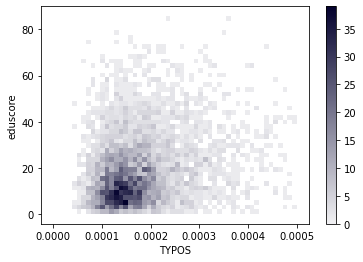

In [162]:
sns.histplot(
    x=uavg_cat_freq.loc[lang.relevant_cells, 'TYPOS'],
    y=wavg_ses.loc[lang.relevant_cells, 'eduscore'],
    binrange=((0, 5e-4), None),
    cmap="light:#03012d",
    cbar=True,
)

/home/thomaslouf/.conda/envs/ses-ling/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='TYPOS', ylabel='imdscore'>

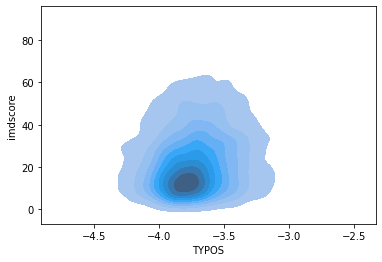

In [58]:
sns.kdeplot(
    x=np.log10(uavg_cat_freq.loc[lang.relevant_cells, 'TYPOS']),
    y=wavg_ses.loc[lang.relevant_cells, 'imdscore'],
    fill=True,
)

next, when actual good correlation, sns.regplot / lmplot